# simulator.ipynb
This is the main Jupyter notebook used to document progress and understanding of the current code library for the SPM.

The main library referenced in this notebook will be https://github.com/RichardLiuCoding/spmsimu/, used to simulate traces and retraces.

In [21]:
# Install the required libraries
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Import required components
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from spmsimu.simulator import *


Now that the basic components have been imported, we can assess the possibilities of the simulator in creating traces and retraces.


Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
The two tips are separated by offset.
Everything is in the unit of pixels.



array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(256, 256))

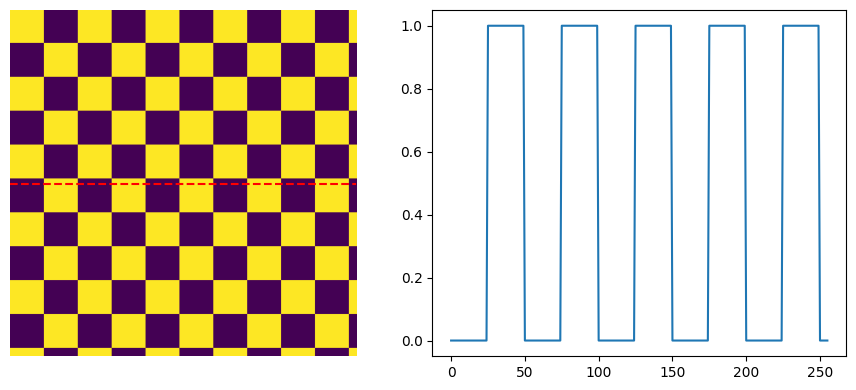

In [23]:
print(generate_doubletip_kernel.__doc__)
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=True)

# The value of the generation is a 2D map with a singular value that determines its height.
checkerboard[:, :]

The function call to generate images uses the horizontal line (red-dashed) to show
hat you can define the region at which you scan.

This is important for the scanning probe microscope as it allows us to directly correlate
the relationship between what we "see" and what the data actually looks like.

For the simulator in this case, we know that we are working with 2D numpy arrays with a single
variable attached to each point in the array.

This leads us to having the ability to use **point-based estimation** for errors, if needed.

Instead, for now, let us define a way to pass in a function to define the image.

array([[ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445],
       [ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445],
       [ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445],
       ...,
       [ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445],
       [ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445],
       [ 0.        ,  1.55740772, -2.18503986, ..., -9.79006006,
        -0.50671472,  0.58725445]], shape=(256, 256))

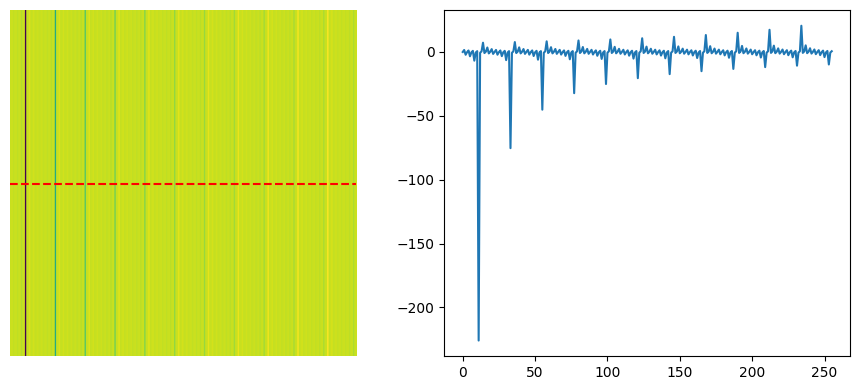

In [24]:
def generate_function_pattern(nx, ny, function = np.ceil, show = False):
    """
    This is a function to generate a map within a square region around the origin, given that
    a standard function or lambda is passed in.

    Inputs:
    nx - int:                   Number of pixels in x-direction
    ny - int:                   Number of pixels in y-direction
    function - lambda:          Function to be modeled around origin (center of image)
    show - bool:                If True, show the plot

    Output:
        pattern_map - ndarray:  2D map with generated pattern
    """
    output = np.zeros((nx, ny))

    # With the given default sin function, we can now modify the zeroed array to contain
    # height map values based on the effects of the function. This is just a double-for
    # loop to scan across the grid.
    for y in range(0, ny, 1):
        for x in range (0, nx, 1):
            output[x, y] = function(y)

    if show:
        fig,ax=plt.subplots(1,2,figsize=[9,4])
        ax[0].imshow(output)
        ax[0].axhline(nx//2, linestyle='--', color='red')
        ax[0].axis('off')
        ax[1].plot(output[nx//2,:])
        plt.tight_layout()

    return output
    
# Sample usage
generate_function_pattern(256, 256, function = lambda x: np.tan(x), show = True)
    

So, now that we can generate any type of function, we can start to assess how errors in traces and retraces occur.

To do some research about the functionality of a SPM, we will look at some of these resources online:
+ https://www.nanophys.kth.se/nanolab/afm/icon/bruker-help/Content/SPM%20Training%20Guide/How%20an%20SPM%20Works.htm
+ https://www.semitracks.com/reference-material/failure-and-yield-analysis/failure-analysis-die-level/scanning-probe-microscopy.php
+ https://en.wikipedia.org/wiki/Scanning_probe_microscopy

## Probe and Scanner
The **probe** is the point of interface between the SPM and the sample material.
The **scanner** controls the precise position of the probe in relation to the surface (vertically and horizontally).

The scanner moves the probe over the material's surface in a precise pattern called the **raster** pattern. These are a series of zig-zag steps covering a square/rectangular area. This brings us to the tracing and retracing of the sample.

Data can be collected as the probe moves **left to right, during the trace**, and **right to left, during the retrace**. The discrepancies between these scanning modes is what we want to reduce and identify in this notebook.

The way that you can *experimentally optimize* the trace and retrace is by checking how they track during tapping mode. There are several methods that you can use to remedy issues with tracking or errors, such as :
+ Adjusting gains
+ Changing scan rate
+ Moving the set point
+ Changing integral/proportional gain

So what we want to do is to be able to first *detect* when a failure occurs with the retrace. We can now connect other repositories to allow us to use sample data.

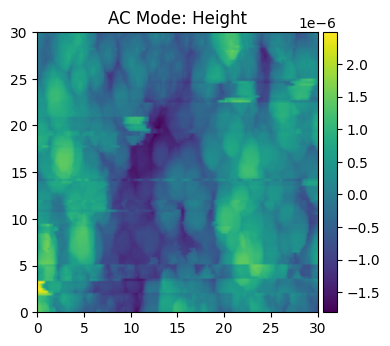

In [25]:
import aespm.tools as at

"""
You can either collect a series of .ibw files in a folder and load them using:
display_ibw_folder(folder, mode=None, key=['Height'], cmaps=None, paras=None, save=None, **kwargs):

Otherwise it is recommended that you use the single-ibw function:
"""
file = "sample_data/bad_images/PositionC_30Cs70M0000.ibw"
at.display_ibw(file, key = ['Height'])

## Relationship of Images to Data
What we want to do now is take an image file, as shown above, and transfer it into a datastructure that can be manipulated or viewed more easily.

Luckily, the given library allows us to take the data from any object read and store it as a numpy array.

In [26]:
from aespm import ibw_read

def create_test_dataframe(file):
    """Create dataframe from IBW file with flexible channel support"""
    ibw = ibw_read(file)
    
    # Get dimensions directly from data shape
    if ibw.data.ndim == 3:
        side_y, side_x, channels = ibw.data.shape
    else:
        raise ValueError(f"Expected 3D data, got shape: {ibw.data.shape}")
    
    reshaped = ibw.data.reshape(-1, channels)
    rows, cols = np.meshgrid(range(side_y), range(side_x), indexing='ij')
    rows_flat = rows.flatten()
    cols_flat = cols.flatten()
    
    # Create dataframe with dynamic columns based on available channels
    df_dict = {
        'row': rows_flat,
        'col': cols_flat,
    }
    
    # Add all channels dynamically
    for i, channel_name in enumerate(ibw.channels):
        df_dict[channel_name] = reshaped[:, i]
    
    df = pd.DataFrame(df_dict)
    
    print(f"Size of data (rows): {len(ibw.z)}")
    print(f"Current mode: {ibw.mode}")
    print(f"Channels: {ibw.channels}")
    print(f"Size (meters): {ibw.size}")
    
    df.to_csv('image_data.csv', index=False)
    return df

# Example usage
file = "sample_data/good_images/PTO_AC_0006.ibw"
df = create_test_dataframe(file)


Size of data (rows): 256
Current mode: DART Mode
Channels: ['Height', 'Amplitude1', 'Amplitude2', 'Phase1', 'Phase2', 'Frequency']
Size (meters): 2.5e-06


Now we have an interface to bring data points into this environment. This will be useful for training any ML model that we need. Since I've already written a basic script to train ML models, we can easily use that to determine the best model in terms of prediction. But, the next section must cover **how to determine 'failure'** in these traces.

## Determining Failures at the Image Level
Since the given `.ibw` files contain several kinds of channels, it is best to use four channels that *most* of them contain. These channels are:
+ Height
+ Amplitude
+ Phase
+ ZSensor

The method that we can statistically check the impact of these variables on what is a "good" image or not will be done with:
+ Bounds checking (away from 'normal')
+ Entropy checking (large amounts of change)
+ Skew checking
+ Machine Learning Algorithm (Random Forests Classifier)


In [27]:
import os

def compute_channel_stats(values):
    """Compute statistical features for a channel"""
    mean = np.mean(values)
    std = np.std(values)
    median = np.median(values)
    value_range = np.ptp(values)
    
    # Compute entropy with better handling of edge cases
    hist, _ = np.histogram(values, bins=256, density=True)
    hist = hist[hist > 0]  # Remove zero bins to avoid log issues
    entropy = -np.sum(hist * np.log(hist + 1e-12))
    
    skew = abs(mean - median)  # Using absolute skew measure
    
    return {
        'mean': mean,
        'std': std,
        'median': median,
        'range': value_range,
        'entropy': entropy,
        'skew': skew,
    }

def process_ibw_file(filepath):
    """Process a single IBW file and extract stats for all channels"""
    try:
        ibw = ibw_read(filepath)
        num_channels = ibw.data.shape[-1]
        reshaped = ibw.data.reshape(-1, num_channels)
        
        stats = {}
        for i, ch in enumerate(ibw.channels):
            stats[ch] = compute_channel_stats(reshaped[:, i])
        
        return stats, ibw.channels
    except Exception as e:
        print(f"Error processing {filepath}: {e}")
        return None, None

def compute_pairwise_residual_mean(data1, data2):
    """Compute mean absolute residual between two channels"""
    # Handle both numpy arrays and pandas Series
    if hasattr(data1, 'values'):
        data1 = data1.values
    if hasattr(data2, 'values'):
        data2 = data2.values
    return np.mean(np.abs(data1 - data2))

def collect_all_stats(folder):
    """Collect statistics from all IBW files in folder"""
    stats_by_channel = {}
    pairwise_residuals = {}
    all_channels = set()
    
    files = [f for f in os.listdir(folder) if f.endswith(".ibw")]
    
    for file in files:
        path = os.path.join(folder, file)
        stat_dict, channels = process_ibw_file(path)
        
        if stat_dict and channels:
            all_channels.update(channels)
            
            # Store channel statistics
            for channel, stats in stat_dict.items():
                stats['filename'] = file
                if channel not in stats_by_channel:
                    stats_by_channel[channel] = []
                stats_by_channel[channel].append(stats)
            
            # Compute pairwise residuals for all channel combinations
            try:
                ibw = ibw_read(path)
                num_channels = len(channels)
                reshaped = ibw.data.reshape(-1, num_channels)
                
                for i in range(num_channels):
                    for j in range(i + 1, num_channels):
                        pair_name = f"{channels[i]}_{channels[j]}_residual"
                        residual = compute_pairwise_residual_mean(reshaped[:, i], reshaped[:, j])
                        
                        if pair_name not in pairwise_residuals:
                            pairwise_residuals[pair_name] = []
                        pairwise_residuals[pair_name].append(residual)
                        
            except Exception as e:
                print(f"Error computing residuals for {file}: {e}")
    
    return stats_by_channel, pairwise_residuals, list(all_channels)

def compute_thresholds(stats_by_channel, pairwise_residuals, percentile=90):
    """Compute thresholds for all channels and pairwise residuals"""
    thresholds = {}
    
    # Compute thresholds for individual channels
    for ch, stats_list in stats_by_channel.items():
        df = pd.DataFrame(stats_list)
        thresholds[ch] = {
            'std_thresh': np.percentile(df['std'], percentile),
            'range_thresh': np.percentile(df['range'], percentile),
            'entropy_thresh': np.percentile(df['entropy'], 100 - percentile),  # Lower entropy = more uniform
            'skew_thresh': np.percentile(df['skew'], percentile),
        }
    
    # Compute thresholds for pairwise residuals
    for pair_name, residuals in pairwise_residuals.items():
        residual_mean = np.mean(residuals)
        residual_std = np.std(residuals)
        thresholds[pair_name] = {
            'mean': residual_mean,
            'std': residual_std,
            'threshold': residual_mean + 3 * residual_std
        }
    
    return thresholds

folder = "sample_data/good_images"
stats_by_channel, pairwise_residuals, all_channels = collect_all_stats(folder)

thresholds = compute_thresholds(stats_by_channel, pairwise_residuals)
import pprint
pprint.pprint(thresholds)

{'Amplitude': {'entropy_thresh': np.float64(0.45486396245197536),
               'range_thresh': np.float32(126.60435),
               'skew_thresh': np.float32(27.75546),
               'std_thresh': np.float32(48.075546)},
 'Amplitude1': {'entropy_thresh': np.float64(0.005450539303035576),
                'range_thresh': np.float32(382650.66),
                'skew_thresh': np.float32(61870.125),
                'std_thresh': np.float32(138284.06)},
 'Amplitude1_Amplitude2_residual': {'mean': np.float32(157.42854),
                                    'std': np.float32(0.0),
                                    'threshold': np.float32(157.42854)},
 'Amplitude1_Frequency_residual': {'mean': np.float32(475.5447),
                                   'std': np.float32(0.0),
                                   'threshold': np.float32(475.5447)},
 'Amplitude1_Phase1_residual': {'mean': np.float32(285.6188),
                                'std': np.float32(0.0),
                               

In [28]:
def analyze_folder(folder_path, percentile=90):
    """Complete analysis workflow for a folder of IBW files"""
    print(f"Analyzing folder: {folder_path}")
    
    # Collect statistics
    all_stats, pairwise_residuals, channels = collect_all_stats(folder_path)
    
    print(f"Found channels: {channels}")
    print(f"Number of channel pairs analyzed: {len(pairwise_residuals)}")
    
    # Save individual channel statistics
    for ch, stats in all_stats.items():
        pd.DataFrame(stats).to_csv(f"{ch}_stats.csv", index=False)
    
    # Compute thresholds
    thresholds = compute_thresholds(all_stats, pairwise_residuals, percentile)
    
    print("\nComputed thresholds:")
    pprint.pprint(thresholds)
    
    return thresholds, channels

analyze_folder("sample_data/bad_images")


Analyzing folder: sample_data/bad_images
Found channels: ['Height', 'Potential', 'ZSensor', 'Phase', 'Amplitude']
Number of channel pairs analyzed: 9

Computed thresholds:
{'Amplitude': {'entropy_thresh': np.float64(-0.011107041537141663),
               'range_thresh': np.float32(136.5831),
               'skew_thresh': np.float32(31.965748),
               'std_thresh': np.float32(55.560307)},
 'Amplitude_Phase_residual': {'mean': np.float32(0.89558655),
                              'std': np.float32(0.79505795),
                              'threshold': np.float32(3.2807603)},
 'Amplitude_Potential_residual': {'mean': np.float32(1.494948),
                                  'std': np.float32(0.4789453),
                                  'threshold': np.float32(2.9317842)},
 'Amplitude_ZSensor_residual': {'mean': np.float32(1.1105903),
                                'std': np.float32(1.0966191),
                                'threshold': np.float32(4.400448)},
 'Height': {'entrop

({'Height': {'std_thresh': np.float32(55.663425),
   'range_thresh': np.float32(143.82953),
   'entropy_thresh': np.float64(0.003272870266026656),
   'skew_thresh': np.float32(32.053665)},
  'Amplitude': {'std_thresh': np.float32(55.560307),
   'range_thresh': np.float32(136.5831),
   'entropy_thresh': np.float64(-0.011107041537141663),
   'skew_thresh': np.float32(31.965748)},
  'Phase': {'std_thresh': np.float32(55.499363),
   'range_thresh': np.float32(154.06085),
   'entropy_thresh': np.float64(-0.07064547539210057),
   'skew_thresh': np.float32(31.927042)},
  'ZSensor': {'std_thresh': np.float32(56.385784),
   'range_thresh': np.float32(150.85956),
   'entropy_thresh': np.float64(-0.07590338256529727),
   'skew_thresh': np.float32(32.514946)},
  'Potential': {'std_thresh': np.float32(30.578732),
   'range_thresh': np.float32(128.86015),
   'entropy_thresh': np.float64(1.5175020747727597),
   'skew_thresh': np.float32(17.407026)},
  'Height_Amplitude_residual': {'mean': np.float32(

In [29]:
class ScaledModel:
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
    
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
    
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
    
    @property
    def feature_importances_(self):
        return self.model.feature_importances_

Debugging stats_by_channel:
Keys: ['Height', 'Amplitude', 'Phase', 'ZSensor', 'Potential', 'Amplitude1', 'Amplitude2', 'Phase1', 'Phase2', 'Frequency']
Height: 45 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Amplitude: 44 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Phase: 44 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
ZSensor: 36 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Potential: 8 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Amplitude1: 1 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Amplitude2: 1 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Phase1: 1 items
  Sample item keys: ['mean', 'std', 'median', 'range', 'entropy', 'skew', 'filename']
Phase2: 1 item

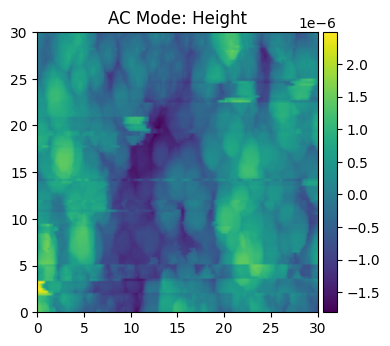

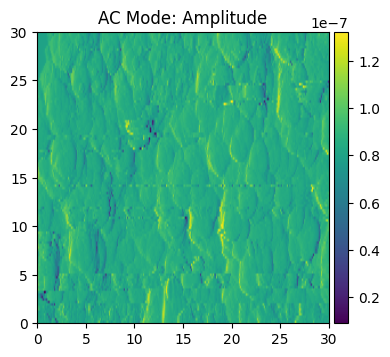

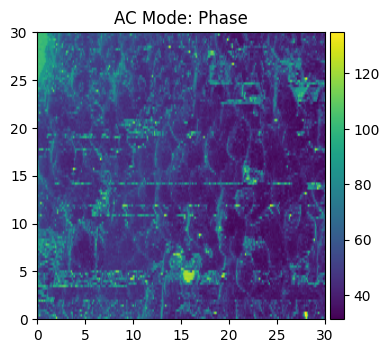

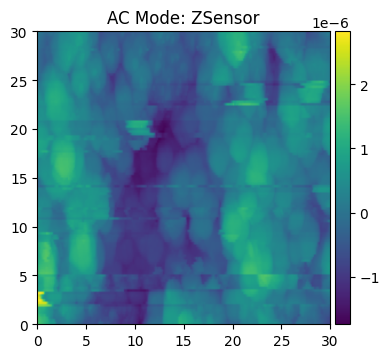

In [30]:
def check_failure_flags(data_dict, thresholds, use_ml=True, ml_model=None):
    """
    Flexible version that works with any number of channels
    """
    results = {}
    
    # FILTER DATA FOR ML CONSISTENCY, only uses these four channels for consistency
    target_channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    if use_ml and ml_model is not None:
        ml_data_dict = {ch: data for ch, data in data_dict.items() 
                        if ch in target_channels}
    else:
        ml_data_dict = data_dict
    
    def compute_features(channel):
        # Handle both numpy arrays and pandas Series
        if hasattr(channel, 'values'):
            channel_flat = channel.values.flatten()
        elif hasattr(channel, 'flatten'):
            channel_flat = channel.flatten()
        else:
            channel_flat = np.array(channel).flatten()
            
        mean = np.mean(channel_flat)
        std = np.std(channel_flat)
        median = np.median(channel_flat)
        range_val = np.ptp(channel_flat)
        hist, _ = np.histogram(channel_flat, bins=256, density=True)
        hist = hist[hist > 0]
        entropy = -np.sum(hist * np.log(hist + 1e-12))
        return mean, std, median, range_val, entropy
    
    # Extract features for all channels dynamically (use original data_dict for traditional analysis)
    channel_features = {}
    for ch_name, ch_data in data_dict.items():
        mean, std, median, range_val, entropy = compute_features(ch_data)
        channel_features[ch_name] = {
            'mean': mean, 'std': std, 'median': median, 
            'range': range_val, 'entropy': entropy
        }
    
    # Generate flags for all channels (use original logic)
    flag_count = 0
    entropy_flags = []
    
    for ch_name, features in channel_features.items():
        if ch_name in thresholds:
            # Individual channel flags
            results[f'{ch_name}_std_flag'] = features['std'] > thresholds[ch_name]['std_thresh']
            results[f'{ch_name}_range_flag'] = features['range'] > thresholds[ch_name]['range_thresh']
            results[f'{ch_name}_entropy_flag'] = features['entropy'] > thresholds[ch_name]['entropy_thresh']
            results[f'{ch_name}_skew_flag'] = abs(features['mean'] - features['median']) > thresholds[ch_name]['skew_thresh']
            
            # Count flags for this channel
            channel_flags = [
                results[f'{ch_name}_std_flag'],
                results[f'{ch_name}_range_flag'], 
                results[f'{ch_name}_entropy_flag'],
                results[f'{ch_name}_skew_flag']
            ]
            flag_count += sum(channel_flags)
            entropy_flags.append(results[f'{ch_name}_entropy_flag'])
    
    # Check pairwise residuals (use original data_dict)
    channel_names = list(data_dict.keys())
    for i in range(len(channel_names)):
        for j in range(i + 1, len(channel_names)):
            ch1, ch2 = channel_names[i], channel_names[j]
            pair_name = f"{ch1}_{ch2}_residual"
            
            if pair_name in thresholds:
                # Convert to numpy arrays if needed
                ch1_data = data_dict[ch1].values if hasattr(data_dict[ch1], 'values') else data_dict[ch1]
                ch2_data = data_dict[ch2].values if hasattr(data_dict[ch2], 'values') else data_dict[ch2]
                
                residual = compute_pairwise_residual_mean(ch1_data.flatten(), ch2_data.flatten())
                results[f'{pair_name}_flag'] = residual > thresholds[pair_name]['threshold']
                flag_count += int(results[f'{pair_name}_flag'])
    
    # Overall failure assessment
    traditional_flags = [flag for key, flag in results.items() if key.endswith('_flag') and isinstance(flag, bool)]
    results['traditional_failure'] = any(traditional_flags)
    results['traditional_failure_count'] = len(traditional_flags)
    results['traditional_failures_flagged'] = sum(traditional_flags)
    
    # Enhanced rule-based logic
    results['multiple_entropy_failure'] = sum(entropy_flags) >= 2
    
    # Compute proximity scores (use original data_dict)
    proximity_scores = []
    proximity_details = {}
    
    for ch_name, features in channel_features.items():
        if ch_name in thresholds:
            std_prox = features['std'] / thresholds[ch_name]['std_thresh'] if thresholds[ch_name]['std_thresh'] > 0 else 0
            range_prox = features['range'] / thresholds[ch_name]['range_thresh'] if thresholds[ch_name]['range_thresh'] > 0 else 0
            skew_prox = abs(features['mean'] - features['median']) / thresholds[ch_name]['skew_thresh'] if thresholds[ch_name]['skew_thresh'] > 0 else 0
            
            proximity_scores.extend([std_prox, range_prox, skew_prox])
            proximity_details[ch_name] = {
                'std_proximity': std_prox,
                'range_proximity': range_prox,
                'skew_proximity': skew_prox
            }
    
    avg_proximity = np.mean(proximity_scores) if proximity_scores else 0
    results['high_proximity_failure'] = avg_proximity > 0.80
    results['proximity_score'] = avg_proximity
    results['proximity_details'] = proximity_details

    # ML-based prediction - FIXED FOR CONSISTENT FEATURE COUNT
    if use_ml and ml_model is not None:
        try:
            # Use only the filtered channels for ML prediction
            ml_channel_features = {}
            for ch_name, ch_data in ml_data_dict.items():
                mean, std, median, range_val, entropy = compute_features(ch_data)
                ml_channel_features[ch_name] = {
                    'mean': mean, 'std': std, 'median': median, 
                    'range': range_val, 'entropy': entropy
                }
            
            # Create feature vector dynamically from filtered channels
            feature_vector = []
            
            # Sort channel names for consistent ordering (same as training)
            sorted_channels = sorted(ml_channel_features.keys())
            
            # Add features for each channel (std, range, entropy, skew)
            for ch_name in sorted_channels:
                features = ml_channel_features[ch_name]
                feature_vector.extend([
                    features['std'],
                    features['range'], 
                    features['entropy'],
                    abs(features['mean'] - features['median'])  # skew
                ])
            
            # Add ALL pairwise residuals for the 4 channels (regardless of thresholds)
            # This ensures we always get the same 6 residuals that were used in training
            for i in range(len(sorted_channels)):
                for j in range(i + 1, len(sorted_channels)):
                    ch1, ch2 = sorted_channels[i], sorted_channels[j]
                    
                    # Compute residual regardless of whether it's in thresholds
                    ch1_data = ml_data_dict[ch1].values if hasattr(ml_data_dict[ch1], 'values') else ml_data_dict[ch1]
                    ch2_data = ml_data_dict[ch2].values if hasattr(ml_data_dict[ch2], 'values') else ml_data_dict[ch2]
                    residual = compute_pairwise_residual_mean(ch1_data.flatten(), ch2_data.flatten())
                    feature_vector.append(residual)
            
            feature_vector = np.array(feature_vector).reshape(1, -1)
            
            print(f"ML feature vector shape: {feature_vector.shape}")  # Debug info
            print(f"Expected features: 4 channels * 4 stats + 6 residuals = 22")
            
            # Get ML prediction
            ml_prob = ml_model.predict_proba(feature_vector)[0][1]  # Probability of being bad
            results['ml_failure_probability'] = ml_prob
            results['ml_failure'] = ml_prob > 0.65
            
            # If it's a tree-based model, get feature importance for this prediction
            if hasattr(ml_model, 'feature_importances_'):
                # Generate feature names dynamically (same as training)
                feature_names = []
                for ch_name in sorted_channels:
                    feature_names.extend([
                        f'{ch_name}_std', f'{ch_name}_range', 
                        f'{ch_name}_entropy', f'{ch_name}_skew'
                    ])
                
                # Add residual feature names (all pairs)
                for i in range(len(sorted_channels)):
                    for j in range(i + 1, len(sorted_channels)):
                        ch1, ch2 = sorted_channels[i], sorted_channels[j]
                        feature_names.append(f'{ch1}_{ch2}_residual')
                
                results['feature_importance'] = dict(zip(feature_names, ml_model.feature_importances_))
                
        except Exception as e:
            print(f"ML prediction failed: {e}")
            results['ml_failure'] = False
            results['ml_failure_probability'] = 0.0
    else:
        results['ml_failure'] = False
        results['ml_failure_probability'] = 0.0
    
    # Count how many of the main failure modes are True (traditional, entropy, proximity, ML)
    sum_fails = sum([
        bool(results['traditional_failure']),
        bool(results['multiple_entropy_failure']),
        bool(results['high_proximity_failure']),
        bool(results['ml_failure'])
    ])

    results['overall_failure'] = sum_fails > 2
    
    # Store raw feature values for analysis - use original data_dict
    results['raw_features'] = {}
    for ch_name, features in channel_features.items():
        results['raw_features'][ch_name] = {
            'mean': features['mean'], 
            'std': features['std'], 
            'median': features['median'], 
            'range': features['range'], 
            'entropy': features['entropy']
        }
    
    # Add residual values to raw features (use original data_dict)
    channel_names = list(data_dict.keys())
    for i in range(len(channel_names)):
        for j in range(i + 1, len(channel_names)):
            ch1, ch2 = channel_names[i], channel_names[j]
            pair_name = f"{ch1}_{ch2}_residual"
            
            if pair_name in thresholds:
                ch1_data = data_dict[ch1].values if hasattr(data_dict[ch1], 'values') else data_dict[ch1]
                ch2_data = data_dict[ch2].values if hasattr(data_dict[ch2], 'values') else data_dict[ch2]
                residual = compute_pairwise_residual_mean(ch1_data.flatten(), ch2_data.flatten())
                results['raw_features'][f'{pair_name}_mean'] = residual
    
    return results


def train_ml_model_matched(all_stats, bad_image_files, good_image_files, ibw_read_func):
    """
    Train ML model using only the 4 channels that check_failure_flags uses
    """
    import numpy as np
    import pandas as pd
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import cross_val_score, train_test_split
    from sklearn.preprocessing import StandardScaler
    import pickle
    import os
    
    print("=== TRAINING ML MODEL (MATCHED TO PREDICTION) ===")
    
    # Use only the 4 channels that the prediction function uses
    target_channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']
    
    available_channels = [ch for ch in target_channels if ch in all_stats and all_stats[ch]]
    
    print(f"Target channels: {target_channels}")
    print(f"Available channels: {available_channels}")
    print(f"Channel sample counts: {[len(all_stats[ch]) for ch in available_channels]}")
    
    if not available_channels:
        print("ERROR: None of the target channels found!")
        return None
    
    # Calculate expected features: 4 stats per channel + pairwise residuals
    num_channels = len(available_channels)
    num_pairs = num_channels * (num_channels - 1) // 2
    expected_features = num_channels * 4 + num_pairs
    print(f"Expected features: {num_channels} channels * 4 stats + {num_pairs} pairs = {expected_features}")
    
    # Handle bad image files
    if isinstance(bad_image_files, str):
        if os.path.isdir(bad_image_files):
            bad_files = [os.path.join(bad_image_files, f) for f in os.listdir(bad_image_files) if f.endswith('.ibw')]
        else:
            bad_files = [bad_image_files]
    else:
        bad_files = bad_image_files
    
    print(f"Found {len(bad_files)} bad image files")
    
    # Prepare feature matrix and labels
    X = []
    y = []
    
    # Feature names for consistency
    feature_names = []
    for ch_name in sorted(available_channels):
        feature_names.extend([f'{ch_name}_std', f'{ch_name}_range', f'{ch_name}_entropy', f'{ch_name}_skew'])
    
    # Add pairwise residual names
    sorted_channels = sorted(available_channels)
    for i in range(len(sorted_channels)):
        for j in range(i + 1, len(sorted_channels)):
            feature_names.append(f'{sorted_channels[i]}_{sorted_channels[j]}_residual')
    
    print(f"Feature names ({len(feature_names)}): {feature_names}")
    
    # Process good images - find files that have ALL required channels
    # Get filenames that appear in all required channels
    channel_filenames = {}
    for ch_name in available_channels:
        channel_filenames[ch_name] = set(stats['filename'] for stats in all_stats[ch_name])
    
    # Find intersection - files that have all channels
    common_files = set.intersection(*channel_filenames.values())
    print(f"Files with all required channels: {len(common_files)}")
    
    for filename in common_files:
        try:
            features = []
            
            # Get features for each channel (in sorted order)
            for ch_name in sorted(available_channels):
                ch_stats = next((s for s in all_stats[ch_name] if s['filename'] == filename), None)
                if ch_stats:
                    features.extend([
                        ch_stats['std'],
                        ch_stats['range'], 
                        ch_stats['entropy'],
                        ch_stats['skew']
                    ])
                else:
                    print(f"Missing {ch_name} for {filename}")
                    raise ValueError(f"Missing channel data")
                
            # Add residuals (again)
            for i in range(len(sorted_channels)):
                for j in range(i + 1, len(sorted_channels)):
                    ch1_name, ch2_name = sorted_channels[i], sorted_channels[j]
                    ch1_stats = next((s for s in all_stats[ch1_name] if s['filename'] == filename), None)
                    ch2_stats = next((s for s in all_stats[ch2_name] if s['filename'] == filename), None)
                    
                    if ch1_stats and ch2_stats:
                        # Simple residual approximation using means
                        residual = abs(ch1_stats['mean'] - ch2_stats['mean'])
                        features.append(residual)
                    else:
                        features.append(0)
            
            if len(features) == expected_features:
                X.append(features)
                y.append(0)  # Good image
            else:
                print(f"Feature count mismatch for {filename}: got {len(features)}, expected {expected_features}")
                
        except Exception as e:
            print(f"Error processing good image {filename}: {e}")
    
    print(f"Processed {len([label for label in y if label == 0])} good images")
    
    # Process bad images - extract the same features
    for bad_file in bad_files:
        try:
            ibw = ibw_read_func(bad_file)
            
            # Create data dictionary like check_failure_flags expects
            data_dict = {}
            
            # You'll need to modify this based on how your ibw_read function works
            # This is a generic approach - adjust based on your data structure
            if hasattr(ibw.data, 'shape'):
                if len(ibw.data.shape) == 3:
                    # Assume channels are in the 3rd dimension
                    num_data_channels = ibw.data.shape[2]
                    # Map to your channel names (you might need to adjust this mapping)
                    channel_mapping = ['Height', 'Amplitude', 'Phase', 'ZSensor'][:num_data_channels]
                    
                    for i, ch_name in enumerate(channel_mapping):
                        if ch_name in available_channels:
                            data_dict[ch_name] = ibw.data[:, :, i]
                            
                elif len(ibw.data.shape) == 2:
                    # Single channel or needs reshaping
                    if len(available_channels) == 1:
                        data_dict[available_channels[0]] = ibw.data
                    else:
                        # Try to split into channels
                        total_size = ibw.data.size
                        if total_size % len(available_channels) == 0:
                            pixels_per_channel = total_size // len(available_channels)
                            flattened = ibw.data.flatten()
                            for i, ch_name in enumerate(sorted(available_channels)):
                                start_idx = i * pixels_per_channel
                                end_idx = (i + 1) * pixels_per_channel
                                data_dict[ch_name] = flattened[start_idx:end_idx]
            
            # Extract features like check_failure_flags does
            features = []
            
            for ch_name in sorted(available_channels):
                if ch_name in data_dict:
                    channel_data = data_dict[ch_name].flatten()
                    
                    mean = np.mean(channel_data)
                    std = np.std(channel_data)
                    median = np.median(channel_data)
                    range_val = np.ptp(channel_data)
                    
                    # Compute entropy
                    hist, _ = np.histogram(channel_data, bins=256, density=True)
                    hist = hist[hist > 0]
                    entropy = -np.sum(hist * np.log(hist + 1e-12)) if len(hist) > 0 else 0
                    
                    skew = abs(mean - median)
                    features.extend([std, range_val, entropy, skew])
                else:
                    # Channel not available, use zeros
                    features.extend([0, 0, 0, 0])
            
            # Add pairwise residuals
            for i in range(len(sorted_channels)):
                for j in range(i + 1, len(sorted_channels)):
                    ch1_name, ch2_name = sorted_channels[i], sorted_channels[j]
                    if ch1_name in data_dict and ch2_name in data_dict:
                        ch1_data = data_dict[ch1_name].flatten()
                        ch2_data = data_dict[ch2_name].flatten()
                        
                        # Ensure same length
                        min_len = min(len(ch1_data), len(ch2_data))
                        residual = np.mean(np.abs(ch1_data[:min_len] - ch2_data[:min_len]))
                        features.append(residual)
                    else:
                        features.append(0)
            
            if len(features) == expected_features:
                X.append(features)
                y.append(1)  # Bad image
            else:
                print(f"Bad image feature mismatch: got {len(features)}, expected {expected_features}")
                
        except Exception as e:
            print(f"Failed to process bad image {os.path.basename(bad_file)}: {e}")
            continue

    X = np.array(X)
    y = np.array(y)
    
    print(f"Final training data: {len(X)} samples, {X.shape[1]} features")
    print(f"Good images: {sum(y == 0)}, Bad images: {sum(y == 1)}")
    
    if len(X) == 0:
        print("No training data available!")
        return None
        
    if len(np.unique(y)) < 2:
        print("ERROR: Need both good and bad samples for training!")
        return None
    
    # Train the model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    print(f"Training accuracy: {train_score:.3f}")
    print(f"Test accuracy: {test_score:.3f}")
    print(f"Cross-validation score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Create combined model
    combined_model = ScaledModel(model, scaler)
    
    with open('image_quality_model.pkl', 'wb') as f:
        pickle.dump(combined_model, f)
    
    print("Model saved as 'image_quality_model.pkl'")
    return combined_model

class ScaledModel:
    """Wrapper class to combine model and scaler"""
    def __init__(self, model, scaler):
        self.model = model
        self.scaler = scaler
        
    def predict(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)
        
    def predict_proba(self, X):
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)
        
    @property
    def feature_importances_(self):
        return self.model.feature_importances_


def load_ml_model(model_path='image_quality_model.pkl'):
    """Load a trained ML model"""
    import pickle
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"Loaded ML model from {model_path}")
        return model
    except FileNotFoundError:
        print(f"No ML model found at {model_path}. Train a model first or use use_ml=False")
        return None
    except Exception as e:
        print(f"Error loading ML model: {e}")
        return None


def enhanced_analysis(results):
    """Print detailed analysis of failure detection results - MADE DYNAMIC"""
    print("=== ENHANCED FAILURE ANALYSIS ===")
    
    print(f"Traditional failure: {results['traditional_failure']} (score: {results['traditional_failures_flagged']} of {results['traditional_failure_count']})")

    # Count entropy flags dynamically
    entropy_flag_count = sum(1 for key, value in results.items() 
                           if key.endswith('_entropy_flag') and value)
    total_entropy_flags = sum(1 for key in results.keys() 
                            if key.endswith('_entropy_flag'))
    
    print(f"Multiple entropy failure: {results['multiple_entropy_failure']} (score: {entropy_flag_count} flags of {total_entropy_flags})")
    
    print(f"High proximity failure: {results['high_proximity_failure']} (score: {results['proximity_score']:.3f})")
    print(f"ML failure: {results['ml_failure']} (probability: {results['ml_failure_probability']:.3f})")
    print(f"OVERALL FAILURE: {results['overall_failure']}")
    
    if 'proximity_details' in results:
        print("\n=== PROXIMITY TO THRESHOLDS ===")
        for ch, prox in results['proximity_details'].items():
            print(f"{ch}:")
            for metric, score in prox.items():
                status = "CLOSE" if score > 0.8 else "OK"
                print(f"  {metric}: {score:.3f} {status}")
    
    if 'feature_importance' in results:
        print("\n=== TOP CONTRIBUTING FEATURES (ML) ===")
        sorted_features = sorted(results['feature_importance'].items(), key=lambda x: x[1], reverse=True)
        for feature, importance in sorted_features[:8]:
            print(f"{feature}: {importance:.3f}")

"""
Testing procedure for some images. You can feed the image file into this if needed.
"""
bad_image_folder = 'sample_data/bad_images/' 
# Unpack all_stats tuple for compatibility with train_ml_model
# Add this before training to debug
print("Debugging stats_by_channel:")
print("Keys:", list(stats_by_channel.keys()))
for key, value in stats_by_channel.items():
    print(f"{key}: {len(value)} items")
    if value:
        print(f"  Sample item keys: {list(value[0].keys())}")

print("Stats by channel keys:", list(stats_by_channel.keys()))
print("Sample stats:", {k: len(v) for k, v in stats_by_channel.items()})

bad_image_folder = 'sample_data/bad_images/'
ml_model = train_ml_model_matched(stats_by_channel, bad_image_folder, "sample_data/good_images", ibw_read)
ml_model = load_ml_model()

file = "sample_data/bad_images/PositionC_30Cs70M0000.ibw"
df = create_test_dataframe(file)
channels = ['Height', 'Amplitude', 'Phase', 'ZSensor']
for i, ch in enumerate(channels):
    row, col = divmod(i, 2)
    at.display_ibw(file, [ch])  # Display IBW for each channel

results = check_failure_flags(df, thresholds, True, ml_model)

enhanced_analysis(results)


## Using Generated Images to Train a Model
Since the given data set is limited, we can explore using generated functions to train a model in a way that replicates basic issues with some of these images. This includes finding a mathematical function or noise that we can identify as bad or good from a certain threshold.

Creating synthetic bad image...
Generated dataframe shape: (65536, 6)
Channels: ['Height', 'Amplitude', 'Phase', 'ZSensor']


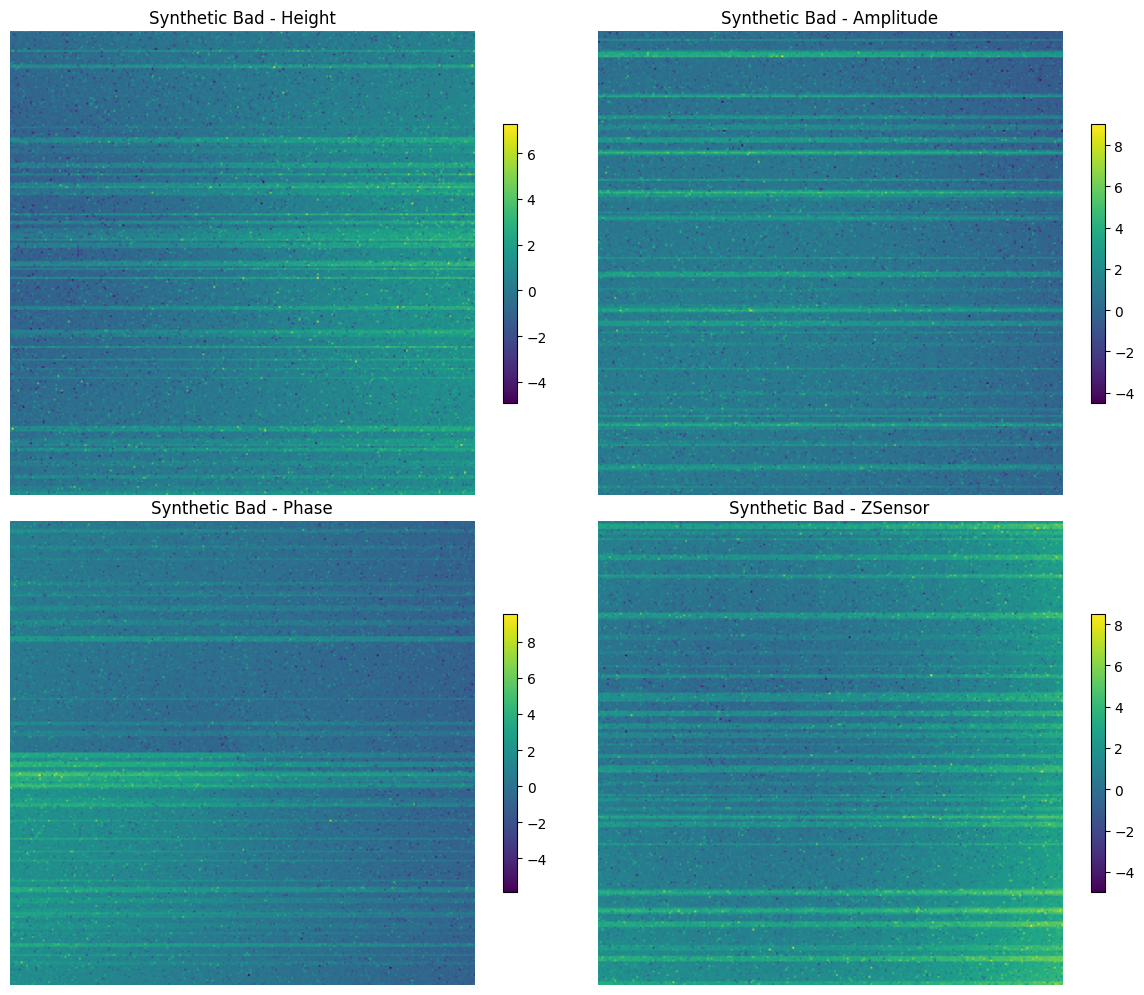


Creating batch of synthetic bad images...
Created 5 synthetic bad images
ML feature vector shape: (1, 22)
Expected features: 4 channels * 4 stats + 6 residuals = 22
=== ENHANCED FAILURE ANALYSIS ===
Traditional failure: False (score: 0 of 0)
Multiple entropy failure: True (score: 4 flags of 4)
High proximity failure: False (score: 0.046)
ML failure: False (probability: 0.630)
OVERALL FAILURE: False

=== PROXIMITY TO THRESHOLDS ===
Height:
  std_proximity: 0.021 OK
  range_proximity: 0.094 OK
  skew_proximity: 0.002 OK
Amplitude:
  std_proximity: 0.022 OK
  range_proximity: 0.107 OK
  skew_proximity: 0.005 OK
Phase:
  std_proximity: 0.026 OK
  range_proximity: 0.122 OK
  skew_proximity: 0.009 OK
ZSensor:
  std_proximity: 0.026 OK
  range_proximity: 0.111 OK
  skew_proximity: 0.006 OK

=== TOP CONTRIBUTING FEATURES (ML) ===
Phase_ZSensor_residual: 0.112
Amplitude_Phase_residual: 0.107
Height_Phase_residual: 0.100
Amplitude_Height_residual: 0.090
Height_ZSensor_residual: 0.080
Amplitude_

In [ ]:
# gradient_noise = lambda x: np.random.normal( np.random.normal(( np.log(x ** 1/100) + np.sqrt(x)), 1) , 1)
# func = lambda x: gradient_noise

# df = generate_function_pattern(256, 256, func, True)

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import pandas as pd

def create_synthetic_bad_image(height=256, width=256, channels=['Height', 'Amplitude', 'Phase', 'ZSensor'], 
                              severity='medium', seed=None):
    """
    Create synthetic bad images with various artifacts that mimic real AFM scan problems
    
    Parameters:
    -----------
    height, width : int
        Image dimensions
    channels : list
        Channel names to generate
    severity : str
        'mild', 'medium', 'severe' - controls artifact intensity
    seed : int
        Random seed for reproducibility
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Severity parameters
    severity_params = {
        'mild': {'noise_scale': 0.5, 'line_prob': 0.05, 'gradient_strength': 0.5, 'scatter_density': 0.1},
        'medium': {'noise_scale': 1.5, 'line_prob': 0.15, 'gradient_strength': 1.0, 'scatter_density': 0.2},
        'severe': {'noise_scale': 2.5, 'line_prob': 0.3, 'gradient_strength': 2.0, 'scatter_density': 0.4}
    }
    params = severity_params[severity]
    
    def gradient_noise_2d(x, y):
        """Enhanced gradient noise function that works with 2D coordinates"""
        # Create position-dependent noise that follows curves/gradients
        r = np.sqrt(x**2 + y**2) + 1e-6  # Avoid division by zero
        angle = np.arctan2(y, x)
        
        # Multi-scale gradient noise
        noise1 = np.random.normal(np.log(r**0.01) + np.sqrt(r/100), params['noise_scale'])
        noise2 = np.random.normal(np.sin(angle * 3) * np.sqrt(r/50), params['noise_scale'] * 0.5)
        
        return noise1 + noise2
    
    def add_horizontal_lines(image, intensity_range=(0.5, 2.0)):
        """Add horizontal line artifacts at random positions"""
        corrupted = image.copy()
        
        # Randomly select rows to corrupt
        num_lines = int(height * params['line_prob'])
        if num_lines > 0:
            corrupted_rows = np.random.choice(height, num_lines, replace=False)
            
            for row in corrupted_rows:
                # Random line characteristics
                line_intensity = np.random.uniform(*intensity_range)
                line_width = np.random.randint(1, 4)  # 1-3 pixels wide
                
                # Add the line with some variation
                for w in range(line_width):
                    if row + w < height:
                        # Add some horizontal variation to make it look more realistic
                        variation = np.random.normal(0, 0.1, width)
                        corrupted[row + w, :] += line_intensity + variation
        
        return corrupted
    
    def add_scattered_noise(image, density=0.2):
        """Add scattered high-intensity noise points"""
        corrupted = image.copy()
        
        # Random scattered points
        num_points = int(height * width * density)
        if num_points > 0:
            rows = np.random.randint(0, height, num_points)
            cols = np.random.randint(0, width, num_points)
            
            # Random intensity spikes
            intensities = np.random.normal(0, params['noise_scale'] * 2, num_points)
            
            for r, c, intensity in zip(rows, cols, intensities):
                corrupted[r, c] += intensity
        
        return corrupted
    
    def add_gradient_drift(image):
        """Add systematic gradient drift across the image"""
        x = np.linspace(-1, 1, width)
        y = np.linspace(-1, 1, height)
        X, Y = np.meshgrid(x, y)
        
        # Random gradient direction and strength
        angle = np.random.uniform(0, 2*np.pi)
        strength = params['gradient_strength'] * np.random.uniform(0.5, 1.5)
        
        gradient = strength * (np.cos(angle) * X + np.sin(angle) * Y)
        
        return image + gradient
    
    def add_stripe_artifacts(image):
        """Add periodic stripe artifacts (common in AFM)"""
        corrupted = image.copy()
        
        # Random stripe parameters
        if np.random.random() < 0.3:  # 30% chance of stripes
            stripe_period = np.random.randint(8, 32)
            stripe_direction = np.random.choice(['horizontal', 'vertical'])
            stripe_amplitude = params['noise_scale'] * 0.3
            
            if stripe_direction == 'horizontal':
                for i in range(height):
                    if i % stripe_period < stripe_period // 2:
                        corrupted[i, :] += stripe_amplitude * np.sin(np.linspace(0, 4*np.pi, width))
            else:
                for j in range(width):
                    if j % stripe_period < stripe_period // 2:
                        corrupted[:, j] += stripe_amplitude * np.sin(np.linspace(0, 4*np.pi, height))
        
        return corrupted
    
    # Generate base images for each channel
    results = {}
    
    for channel in channels:
        # Start with a base pattern that varies by channel
        x = np.linspace(-2, 2, width)
        y = np.linspace(-2, 2, height)
        X, Y = np.meshgrid(x, y)
        
        # Channel-specific base patterns
        if channel == 'Height':
            base = 0.5 * np.sin(X) * np.cos(Y) + 0.3 * np.random.normal(0, 0.1, (height, width))
        elif channel == 'Amplitude':
            base = np.exp(-(X**2 + Y**2)/4) + 0.2 * np.random.normal(0, 0.1, (height, width))
        elif channel == 'Phase':
            base = np.arctan2(Y, X) / np.pi + 0.2 * np.random.normal(0, 0.1, (height, width))
        elif channel == 'ZSensor':
            base = 0.3 * (X**2 + Y**2) + 0.25 * np.random.normal(0, 0.1, (height, width))
        else:
            # Generic pattern for other channels
            base = np.random.normal(0, 0.2, (height, width))
        
        # Apply gradient noise
        gradient_noise_map = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                gradient_noise_map[i, j] = gradient_noise_2d(X[i, j], Y[i, j])
        
        # Combine base pattern with gradient noise
        corrupted = base + gradient_noise_map * 0.3
        
        # Add various artifacts
        corrupted = add_horizontal_lines(corrupted)
        corrupted = add_scattered_noise(corrupted, params['scatter_density'])
        corrupted = add_gradient_drift(corrupted)
        corrupted = add_stripe_artifacts(corrupted)
        
        # Add some smoothing to make it look more realistic
        if np.random.random() < 0.3:  # Sometimes add smoothing
            sigma = np.random.uniform(0.5, 1.5)
            corrupted = ndimage.gaussian_filter(corrupted, sigma)
        
        results[channel] = corrupted
    
    return results

def synthetic_bad_to_dataframe(image_dict, flatten=True):
    """Convert synthetic bad image dictionary to dataframe format"""
    height, width = next(iter(image_dict.values())).shape
    
    data = []
    for i in range(height):
        for j in range(width):
            row_data = {'row': i, 'col': j}
            for channel, image in image_dict.items():
                row_data[channel] = image[i, j]
            data.append(row_data)
    
    df = pd.DataFrame(data)
    
    if flatten:
        # Create flattened versions for each channel (like your original function expects)
        for channel in image_dict.keys():
            df[channel] = image_dict[channel].flatten()
    
    return df

def create_batch_synthetic_bad_images(num_images=10, **kwargs):
    """Create a batch of synthetic bad images with varying characteristics"""
    batch = []
    severities = ['mild', 'medium', 'severe']
    
    for i in range(num_images):
        # Vary parameters for each image
        severity = np.random.choice(severities)
        seed = np.random.randint(0, 10000)
        
        # Randomly vary dimensions slightly
        h = np.random.randint(200, 300)
        w = np.random.randint(200, 300)
        
        image_dict = create_synthetic_bad_image(
            height=h, width=w, 
            severity=severity, 
            seed=seed, 
            **kwargs
        )
        
        df = synthetic_bad_to_dataframe(image_dict)
        batch.append({
            'dataframe': df,
            'image_dict': image_dict,
            'metadata': {'severity': severity, 'seed': seed, 'dimensions': (h, w)}
        })
    
    return batch

def visualize_synthetic_bad_image(image_dict, title_prefix="Synthetic Bad"):
    """Visualize the generated bad images"""
    num_channels = len(image_dict)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, (channel, image) in enumerate(image_dict.items()):
        if idx < 4:  # Only show first 4 channels
            im = axes[idx].imshow(image, cmap='viridis', aspect='equal')
            axes[idx].set_title(f'{title_prefix} - {channel}')
            axes[idx].axis('off')
            plt.colorbar(im, ax=axes[idx], shrink=0.6)
    
    # Hide unused subplots
    for idx in range(len(image_dict), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage and testing
if __name__ == "__main__":
    # Create a single synthetic bad image
    print("Creating synthetic bad image...")
    bad_image = create_synthetic_bad_image(severity='medium', seed=42)
    
    # Convert to dataframe
    df = synthetic_bad_to_dataframe(bad_image)
    print(f"Generated dataframe shape: {df.shape}")
    print(f"Channels: {[col for col in df.columns if col not in ['row', 'col']]}")
    
    # Visualize
    visualize_synthetic_bad_image(bad_image)
    
    # Create a batch
    print("\nCreating batch of synthetic bad images...")
    batch = create_batch_synthetic_bad_images(num_images=5)
    print(f"Created {len(batch)} synthetic bad images")
    
    # Test with your failure detection
    # Assuming you have your thresholds and ml_model loaded:
    results = check_failure_flags(df, thresholds, True, ml_model)
    enhanced_analysis(results)